In [1]:
# Helper packages
library(tidyverse)
# Modeling packages
library(caret) # for cross-validation, etc.
# Model interpretability packages
library(vip) # variable importance

library(rsample)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

Warning message:
"package 'tibble' was built under R version 4.0.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'caret' was built under R version 4.0.3"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'vip' was built under R version 4.0.3"

Attaching package: 'vip'


The following object is masked from 'package:utils':

    vi


Warning message:
"package 'rsample' was built under R version 4.0.3"


In [2]:
ames <- read_csv('data/ames.csv')
set.seed(123)
split <- initial_split(ames, prop = 0.7,
strata = "Sale_Price")
ames_train <- training(split)
ames_test <- testing(split)

Parsed with column specification:
cols(
  .default = col_character(),
  Lot_Frontage = col_double(),
  Lot_Area = col_double(),
  Year_Built = col_double(),
  Year_Remod_Add = col_double(),
  Mas_Vnr_Area = col_double(),
  BsmtFin_SF_1 = col_double(),
  BsmtFin_SF_2 = col_double(),
  Bsmt_Unf_SF = col_double(),
  Total_Bsmt_SF = col_double(),
  First_Flr_SF = col_double(),
  Second_Flr_SF = col_double(),
  Low_Qual_Fin_SF = col_double(),
  Gr_Liv_Area = col_double(),
  Bsmt_Full_Bath = col_double(),
  Bsmt_Half_Bath = col_double(),
  Full_Bath = col_double(),
  Half_Bath = col_double(),
  Bedroom_AbvGr = col_double(),
  Kitchen_AbvGr = col_double(),
  TotRms_AbvGrd = col_double()
  # ... with 15 more columns
)

See spec(...) for full column specifications.



In [3]:
# Simple linear regression
model1 <- lm(Sale_Price ~ Gr_Liv_Area, data = ames_train)

In [4]:
summary(model1)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area, data = ames_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-361143  -30668   -2449   22838  331357 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 8732.938   3996.613   2.185    0.029 *  
Gr_Liv_Area  114.876      2.531  45.385   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 56700 on 2051 degrees of freedom
Multiple R-squared:  0.5011,	Adjusted R-squared:  0.5008 
F-statistic:  2060 on 1 and 2051 DF,  p-value: < 2.2e-16


In [5]:
# Get the error metrics

sigma(model1) # RMSE
sigma(model1)^2 # MSE

[1] 56704.78

[1] 3215432370

In [6]:
confint(model1, level = 0.95)

2.5 %    97.5 %    
(Intercept) 895.0961 16570.7805
Gr_Liv_Area 109.9121   119.8399

In [7]:
(model2 <- lm(Sale_Price ~ Gr_Liv_Area + Year_Built,
data = ames_train))


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train)

Coefficients:
(Intercept)  Gr_Liv_Area   Year_Built  
 -2.123e+06    9.918e+01    1.093e+03  


Alternatively, we can use update() to update the model formula used in model1.
The new formula can use a . as shorthand for keep everything on either the left
or right hand side of the formula, and a + or - can be used to add or remove
terms from the original model, respectively. In the case of adding Year_Built
to model1, we could‚Äôve used:

In [8]:
(model2 <- update(model1, . ~ . + Year_Built))


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built, data = ames_train)

Coefficients:
(Intercept)  Gr_Liv_Area   Year_Built  
 -2.123e+06    9.918e+01    1.093e+03  


In [9]:
# Interaction effect

lm(Sale_Price ~ Gr_Liv_Area + Year_Built + Gr_Liv_Area:Year_Built,
data = ames_train)


Call:
lm(formula = Sale_Price ~ Gr_Liv_Area + Year_Built + Gr_Liv_Area:Year_Built, 
    data = ames_train)

Coefficients:
           (Intercept)             Gr_Liv_Area              Year_Built  
             3.822e+05              -1.484e+03              -1.798e+02  
Gr_Liv_Area:Year_Built  
             8.037e-01  


In [10]:
# include all possible main effects
model3 <- lm(Sale_Price ~ ., data = ames_train)
# print estimated coefficients in a tidy data frame
broom::tidy(model3)

term                                                 estimate     
1   (Intercept)                                          -5.568742e+06
2   MS_SubClassOne_and_Half_Story_Finished_All_Ages       2.324504e+04
3   MS_SubClassOne_and_Half_Story_PUD_All_Ages           -3.241401e+04
4   MS_SubClassOne_and_Half_Story_Unfinished_All_Ages     2.786651e+04
5   MS_SubClassOne_Story_1945_and_Older                   2.269374e+04
6   MS_SubClassOne_Story_1946_and_Newer_All_Styles        1.913570e+04
7   MS_SubClassOne_Story_PUD_1946_and_Newer              -2.946682e+02
8   MS_SubClassOne_Story_with_Finished_Attic_All_Ages     3.192860e+04
9   MS_SubClassPUD_Multilevel_Split_Level_Foyer          -5.851970e+03
10  MS_SubClassSplit_Foyer                                1.474431e+04
11  MS_SubClassSplit_or_Multilevel                        7.685574e+03
12  MS_SubClassTwo_and_Half_Story_All_Ages                5.207673e+03
13  MS_SubClassTwo_Family_conversion_All_Styles_and_Ages  7.532287e+03
14  MS_SubClassTwo_Story_1945_and_Older                   2.627724e+04
15  MS_SubClassTwo_Story_1946_and_Newer                   1.804256e+04
16  MS_SubClassTwo_Story_PUD_1946_and_Newer              -3.749707e+03
17  MS_ZoningC_all                                       -2.528291e+04
18  MS_ZoningFloating_Village_Residential                -1.295797e+04
19  MS_ZoningI_all                                       -7.840755e+03
20  MS_ZoningResidential_High_Density                    -1.189714e+04
21  MS_ZoningResidential_Low_Density                     -1.257261e+04
22  MS_ZoningResidential_Medium_Density                  -1.643270e+04
23  Lot_Frontage                                         -2.160345e+00
24  Lot_Area                                              4.640662e-01
25  StreetPave                                            5.340140e+03
26  AlleyNo_Alley_Access                                  4.476049e+02
27  AlleyPaved                                            2.646030e+03
28  Lot_ShapeModerately_Irregular                        -1.611070e+03
29  Lot_ShapeRegular                                     -6.755599e+03
30  Lot_ShapeSlightly_Irregular                          -7.492827e+03
... ...                                                  ...          
263 Pool_QCFair                                          -72586.898580
264 Pool_QCGood                                          -65605.229947
265 Pool_QCNo_Pool                                       -25040.424880
266 Pool_QCTypical                                       -74381.326067
267 FenceGood_Wood                                         1828.356332
268 FenceMinimum_Privacy                                   4894.052471
269 FenceMinimum_Wood_Wire                                 7406.465984
270 FenceNo_Fence                                          3057.700282
271 Misc_FeatureNone                                      -1269.968771
272 Misc_FeatureOthr                                      -1748.660018
273 Misc_FeatureShed                                       -156.014969
274 Misc_Val                                                  1.000726
275 Mo_Sold                                                -231.651411
276 Year_Sold                                              -565.907221
277 Sale_TypeCon                                          25376.655357
278 Sale_TypeConLD                                         5686.823751
279 Sale_TypeConLI                                        -6191.755598
280 Sale_TypeConLw                                         6600.567733
281 Sale_TypeCWD                                           8939.118665
282 Sale_TypeNew                                            426.054695
283 Sale_TypeOth                                           3098.626834
284 Sale_TypeVWD                                         -11532.387679
285 Sale_TypeWD                                            2452.370596
286 Sale_ConditionAdjLand                                 21948.335162
287 Sale_ConditionAlloca    

In [11]:
# Train model using 10-fold cross-validation
set.seed(123) # for reproducibility
(cv_model1 <- train(
form = Sale_Price ~ Gr_Liv_Area,
data = ames_train,
method = "lm",
trControl = trainControl(method = "cv", number = 10)
))

Linear Regression 

2053 samples
   1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1846, 1848, 1848, 1848, 1848, 1848, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  56410.89  0.5069425  39169.09

Tuning parameter 'intercept' was held constant at a value of TRUE

The resulting cross-validated RMSE is 55,670.37 (this is the average RMSE
across the 10 CV folds). How should we interpret this? When applied to unseen
data, the predictions this model makes are, on average, about $55,670.37 off
from the actual sale price.

In [12]:
# model 2 CV
set.seed(123)
cv_model2 <- train(
Sale_Price ~ Gr_Liv_Area + Year_Built,
data = ames_train,
method = "lm",
trControl = trainControl(method = "cv", number = 10)
)

# model 3 CV
set.seed(123)
cv_model3 <- train(
Sale_Price ~ .,
data = ames_train,
method = "lm",
trControl = trainControl(method = "cv", number = 10)
)
# Extract out of sample performance measures
summary(resamples(list(
model1 = cv_model1,
model2 = cv_model2,
model3 = cv_model3
)))

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFi


Call:
summary.resamples(object = resamples(list(model1 = cv_model1, model2
 = cv_model2, model3 = cv_model3)))

Models: model1, model2, model3 
Number of resamples: 10 

MAE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
model1 34457.58 36323.74 38943.81 39169.09 41660.81 45005.17    0
model2 28094.79 30594.47 31959.30 32246.86 34210.70 37441.82    0
model3 12458.27 15363.61 16484.77 16251.30 17262.39 19029.29    0

RMSE 
           Min.  1st Qu.   Median     Mean  3rd Qu.     Max. NA's
model1 47211.34 52363.41 54948.96 56410.89 60672.31 67679.05    0
model2 37698.17 42607.11 45407.14 46292.38 49668.59 54692.06    0
model3 20844.33 22581.04 24947.45 26074.77 27695.65 39521.49    0

Rsquared 
            Min.   1st Qu.    Median      Mean   3rd Qu.      Max. NA's
model1 0.3598237 0.4550791 0.5289068 0.5069425 0.5619841 0.5965793    0
model2 0.5714665 0.6392504 0.6800818 0.6703298 0.7067458 0.7348562    0
model3 0.7869022 0.9018567 0.9104351 0.8951605 0.9172506 0.930

In [13]:
?resamples

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ x'



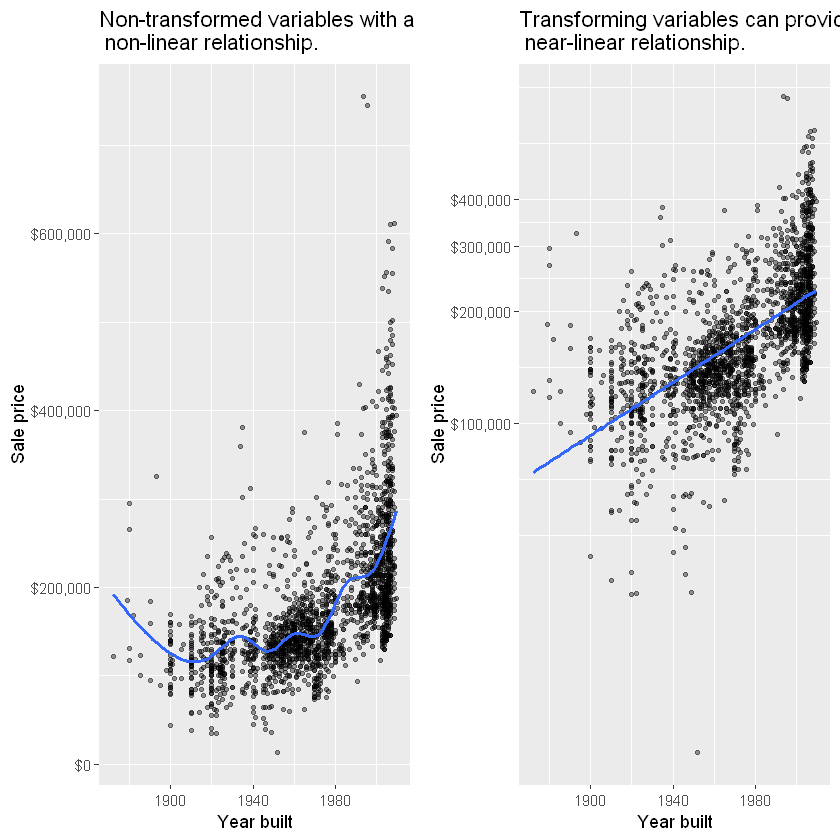

In [14]:
# Linear vs nonlinear relationships

p1 <- ggplot(ames_train, aes(Year_Built, Sale_Price)) +
geom_point(size = 1, alpha = .4) +
geom_smooth(se = FALSE) +
scale_y_continuous("Sale price", labels = scales::dollar) +
xlab("Year built") +
ggtitle(paste("Non-transformed variables with a\n",
"non-linear relationship."))
p2 <- ggplot(ames_train, aes(Year_Built, Sale_Price)) +
geom_point(size = 1, alpha = .4) +
geom_smooth(method = "lm", se = FALSE) +
scale_y_log10("Sale price", labels = scales::dollar,
breaks = seq(0, 400000, by = 100000)) +
xlab("Year built") +
ggtitle(paste("Transforming variables can provide a\n",
"near-linear relationship."))
gridExtra::grid.arrange(p1, p2, nrow = 1)

The broom::augment function is an easy way to add model results to each
observation (i.e. predicted values, residuals).

Warning message:
"Removed 18 rows containing missing values (geom_point)."


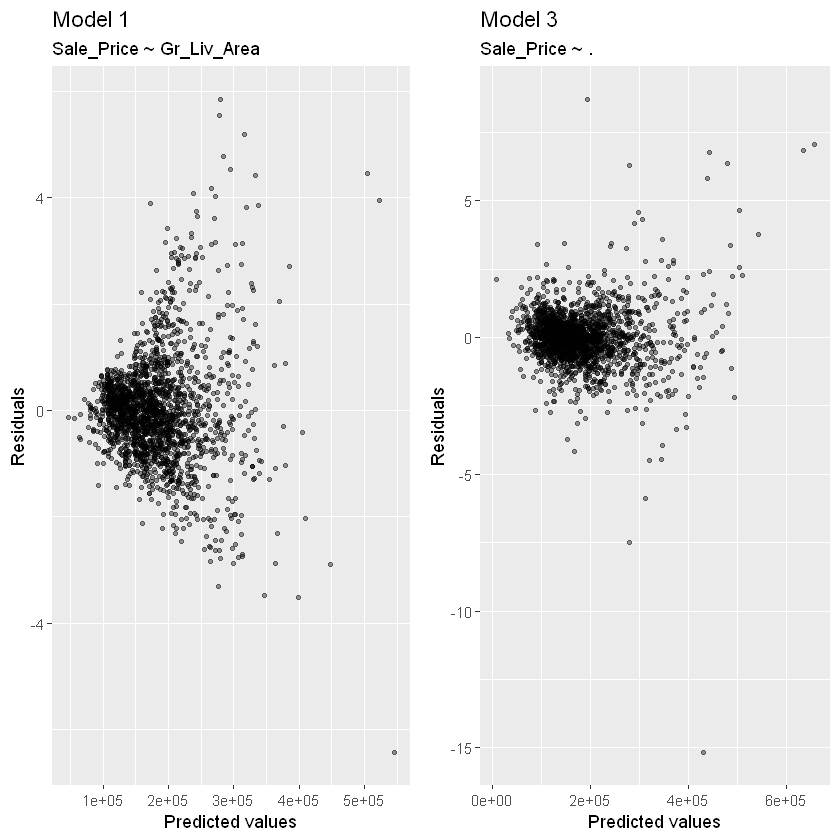

In [15]:
df1 <- broom::augment(cv_model1$finalModel, data = ames_train)

p1 <- ggplot(df1, aes(.fitted, .std.resid)) +
    geom_point(size = 1, alpha = .4) +
    xlab("Predicted values") +
    ylab("Residuals") +
    ggtitle("Model 1", subtitle = "Sale_Price ~ Gr_Liv_Area")

df2 <- broom::augment(cv_model3$finalModel, data = ames_train)


p2 <- ggplot(df2, aes(.fitted, .std.resid)) +
    geom_point(size = 1, alpha = .4) +
    xlab("Predicted values") +
    ylab("Residuals") +
    ggtitle("Model 3", subtitle = "Sale_Price ~ .")


gridExtra::grid.arrange(p1, p2, nrow = 1)

In [16]:
glimpse(df1)

Rows: 2,053
Columns: 86
$ MS_SubClass        <chr> "One_Story_1946_and_Newer_All_Styles", "One_Stor...
$ MS_Zoning          <chr> "Residential_Low_Density", "Residential_High_Den...
$ Lot_Frontage       <dbl> 141, 80, 81, 78, 41, 39, 60, 75, 63, 85, 47, 152...
$ Lot_Area           <dbl> 31770, 11622, 14267, 9978, 4920, 5389, 7500, 100...
$ Street             <chr> "Pave", "Pave", "Pave", "Pave", "Pave", "Pave", ...
$ Alley              <chr> "No_Alley_Access", "No_Alley_Access", "No_Alley_...
$ Lot_Shape          <chr> "Slightly_Irregular", "Regular", "Slightly_Irreg...
$ Land_Contour       <chr> "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", "Lvl", "Lvl",...
$ Utilities          <chr> "AllPub", "AllPub", "AllPub", "AllPub", "AllPub"...
$ Lot_Config         <chr> "Corner", "Inside", "Corner", "Inside", "Inside"...
$ Land_Slope         <chr> "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", "Gtl", "Gtl",...
$ Neighborhood       <chr> "North_Ames", "North_Ames", "North_Ames", "Gilbe...
$ Condition_1        <chr> "

Warning message:
"Removed 18 rows containing missing values (geom_point)."


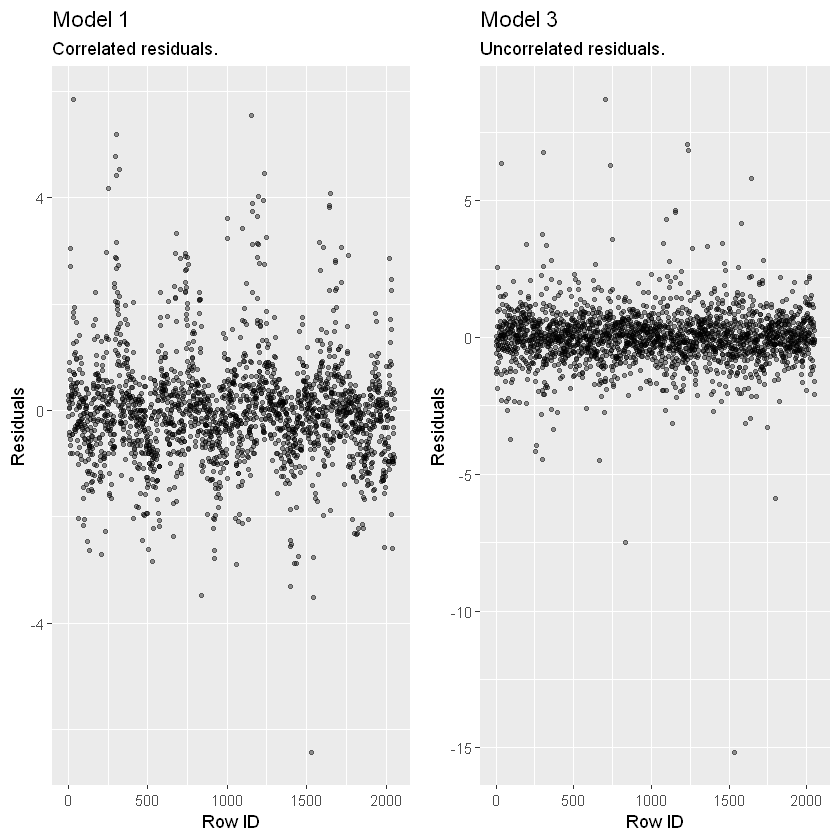

In [17]:
# Check for autocorrelation

df1 <- mutate(df1, id = row_number())

df2 <- mutate(df2, id = row_number())
p1 <- ggplot(df1, aes(id, .std.resid)) +
geom_point(size = 1, alpha = .4) +
xlab("Row ID") +
ylab("Residuals") +
ggtitle("Model 1", subtitle = "Correlated residuals.")
p2 <- ggplot(df2, aes(id, .std.resid)) +
geom_point(size = 1, alpha = .4) +
xlab("Row ID") +
ylab("Residuals") +
ggtitle("Model 3", subtitle = "Uncorrelated residuals.")
gridExtra::grid.arrange(p1, p2, nrow = 1)

In [18]:
# fit with two strongly correlated variables
summary(cv_model3) %>%
    broom::tidy() %>%
    filter(term %in% c("Garage_Area", "Garage_Cars"))

term        estimate   std.error   statistic p.value    
1 Garage_Cars 3020.85403 1771.093788 1.705643  0.088249983
2 Garage_Area   19.67727    6.029965 3.263248  0.001122415

However, if we refit the full model without Garage_Cars, the coefficient estimate
for Garage_Area increases two fold and becomes statistically significant

In [20]:
# model without Garage_Area
set.seed(123)

mod_wo_Garage_Cars <- train(
    Sale_Price ~ .,
    data = select(ames_train, -Garage_Cars),
    method = "lm",
    trControl = trainControl(method = "cv", number = 10)
    )

summary(mod_wo_Garage_Cars) %>%
    broom::tidy() %>%
    filter(term == "Garage_Area")

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFi

term        estimate std.error statistic p.value     
1 Garage_Area 27.04567 4.209165  6.425423  1.685745e-10

Principal component regression -- feed the factor scores in as regression predictors

Performing PCR with caret is an easy extension from our previous model.
We simply specify method = ‚Äùpcr‚Äù within train() to perform PCA on all our
numeric predictors prior to fitting the model.

In [21]:
# model without Garage_Area

set.seed(123)

mod_wo_Garage_Cars <- train(
    Sale_Price ~ .,
    data = select(ames_train, -Garage_Cars),
    method = "lm",
    trControl = trainControl(method = "cv", number = 10)
)

summary(mod_wo_Garage_Cars) %>%
    broom::tidy() %>%
    filter(term == "Garage_Area")

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(modelFi

term        estimate std.error statistic p.value     
1 Garage_Area 27.04567 4.209165  6.425423  1.685745e-10

## Partial least squares

ncomp
16 16

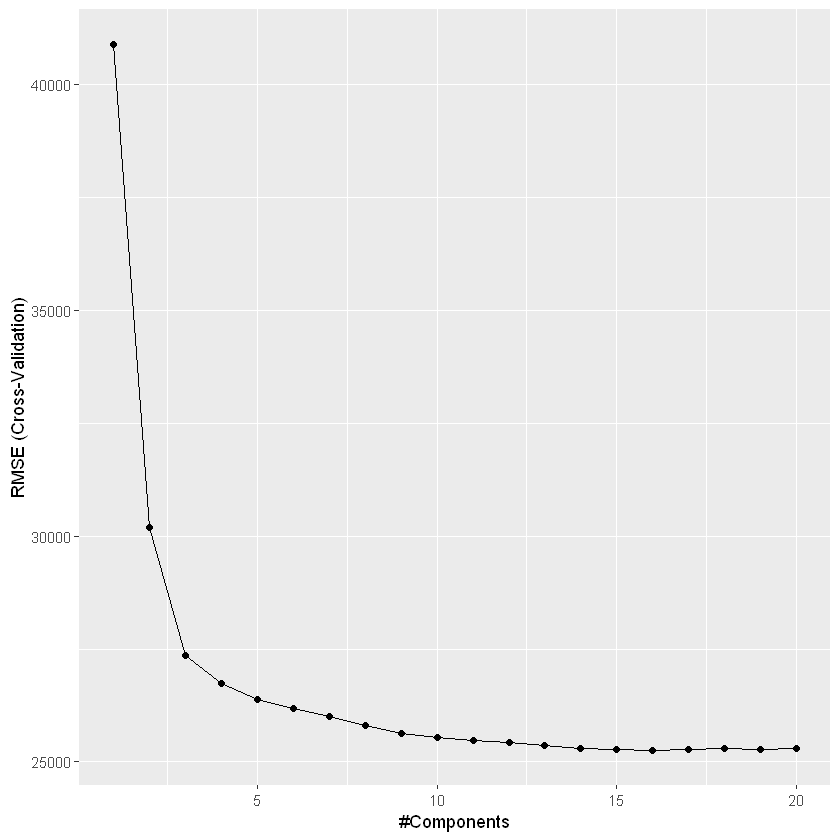

In [25]:
# perform 10-fold cross validation on a PLS model tuning the
# number of principal components to use as predictors from 1-20
set.seed(123)

cv_model_pls <- train(
    Sale_Price ~ .,
    data = ames_train,
    method = "pls",
    trControl = trainControl(method = "cv", number = 10),
    preProcess = c("zv", "center", "scale"),
    tuneLength = 20
)

# model with lowest RMSE
cv_model_pls$bestTune

# plot cross-validated RMSE
ggplot(cv_model_pls)

We can use vip::vip() to extract and plot the most important variables. The
importance measure is normalized from 100 (most important) to 0 (least
important).

Warning message:
"package 'pls' was built under R version 4.0.3"

Attaching package: 'pls'


The following object is masked from 'package:caret':

    R2


The following object is masked from 'package:stats':

    loadings




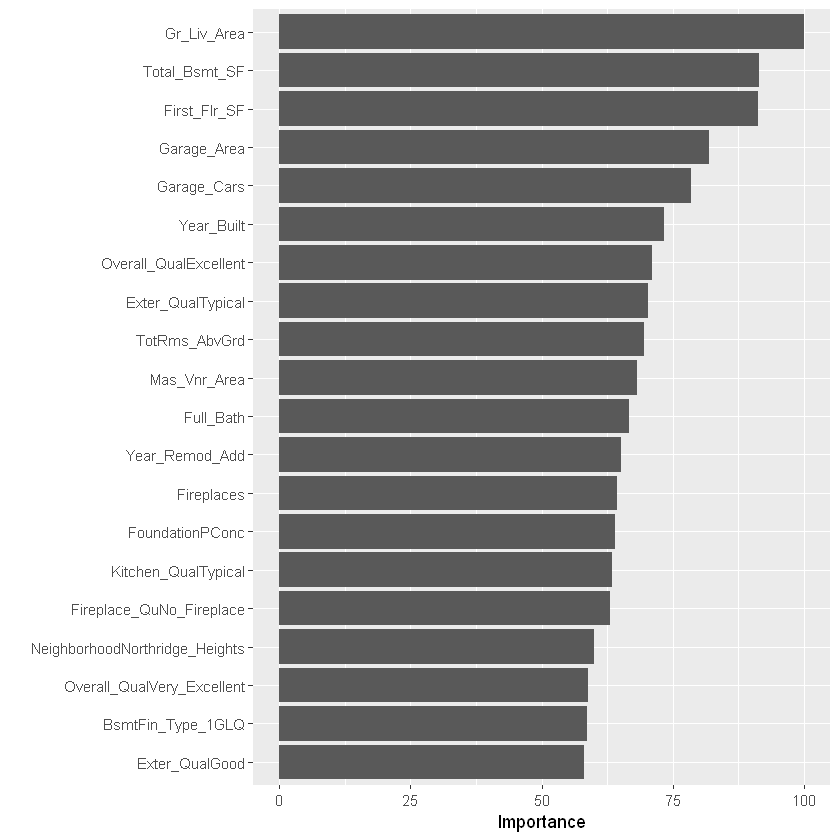

In [27]:
vip(cv_model_pls, num_features = 20, method = "model")

we can construct partial dependence plots (PDPs).
PDPs plot the change in the average predicted value (ùë¶)ÃÇ as specified feature(s)
vary over their marginal distribution.

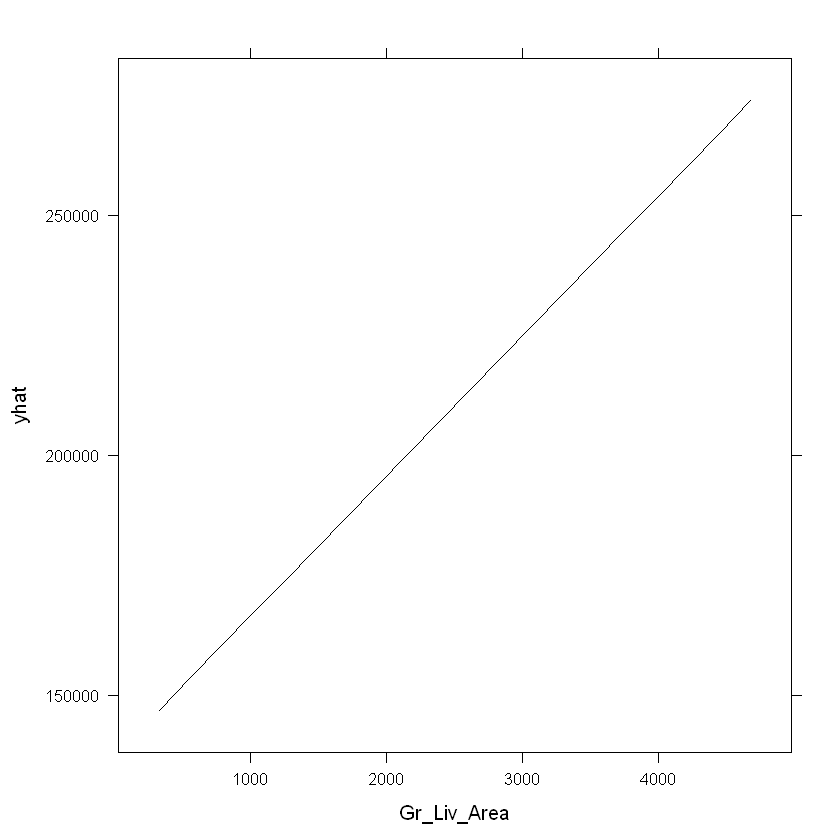

In [31]:
pdp::partial(cv_model_pls, "Gr_Liv_Area", grid.resolution = 20, plot = TRUE)